In [72]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  

year  = (1*u.year).cgs.value
au    = c.au.cgs.value
M_jup = c.M_jup.cgs.value
M_sun = c.M_sun.cgs.value

gl_alpha = None

from simple_slider import Widget
from simple_slider import kanagawa_profile
from simple_slider import get_surface_density
from simple_slider import get_disk_height

%matplotlib notebook

In [73]:
import simple_slider
import os

Select the number of planets

Choices: [1,3]

In [74]:
gl_n_planets = 3

Optional: Set desired alpha here (uncomment first line)

In [75]:
# gl_alpha = 1e-3
try:
    set_alpha = int(gl_alpha**0)
except Exception:
    set_alpha = 0

In [76]:
if gl_n_planets == 3:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_3_planets')
elif gl_n_planets == 1:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_1_planet')
else:
    print("please select valid directory")
r = (np.loadtxt(os.path.join(data_dir, 'radius.dat')))
sigma = np.loadtxt(os.path.join(data_dir, 'sigma_averaged.dat'), unpack=1)
time = np.loadtxt(os.path.join(data_dir, 'time.dat'))

Interpolate on a log grid

In [77]:
n_points = 500
r_log = np.logspace(np.log10(20), np.log10(400), n_points) * au
sigma_log = 10.**np.array([np.interp(np.log10(r_log), np.log10(r), np.log10(sig)) for sig in sigma.T]).T


Select the snapshot

In [78]:
t   = time.searchsorted(5 * 1e4 * year)
#t  = 0
sig = sigma_log[:, t]

Define the logp function: create a model based on the parameters and compare it to the data

In [79]:
from log_prob import logp, log_prior, log_prob, conv_values, params_format, log_prob_alpha

def log_prob_alpha(params, x_data, y_data, n_planets, masks, gl_alpha):
    params = [gl_alpha] + params
    lp = logprior(params, x_data, n_planets, masks)
    if not np.isfinite(lp):
        return -np.inf
    return logp(params, x_data, ydata, n_planets)

In [80]:
import emcee
from multiprocessing import Pool
from scipy.signal import argrelmin

nwalkers = 300
ndim = 3 + 2 * gl_n_planets - set_alpha
n_burnin = 500
n_steps = 700
pos = np.random.rand(nwalkers, ndim)

if gl_alpha is not None:
    pos = np.insert(pos,0,0,axis=1)

pos = conv_values(pos, r_log, gl_n_planets)
if gl_n_planets == 3:
    # find local minima
    peaks_mask = argrelmin(sig, order=int(n_points/33))
    rps = r_log[peaks_mask]
    # place Gaussians around minima as starting guesses
    pos[:,3] = (rps[0]*(1+np.random.randn(pos.shape[0])*0.025))
    pos[:,5] = (rps[1]*(1+np.random.randn(pos.shape[0])*0.025))
    pos[:,7] = (rps[2]*(1+np.random.randn(pos.shape[0])*0.025))
masks = [conv_values(np.ones_like(pos[0]), r_log, gl_n_planets), conv_values(np.zeros_like(pos[0]), r_log, gl_n_planets)]


if gl_alpha is not None:
    pos = pos[:,1:]
#nwalkers, ndim = pos.shape

In [95]:
with Pool() as pool:
    if gl_alpha is None:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob,args=(r_log, sig, gl_n_planets, masks), pool=pool)
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_alpha,args=(r_log, sig, gl_n_planets, masks, gl_alpha), pool=pool)
    state = sampler.run_mcmc(pos, n_burnin, progress=True)
       
    new_pos             = state.coords.copy()
    # set multiplier at the end to ~1.15 to remove single outliers
    good_mask           = sampler.lnprobability[:, -1] > np.median(sampler.lnprobability[:, -1]) * 3
    good_indices        = np.where(good_mask)[0]
    new_good_indices    = np.random.choice(good_indices, size=(~good_mask).sum())
    new_pos[~good_mask] = new_pos[new_good_indices]

    sampler.reset()

    sampler.run_mcmc(new_pos, n_steps, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:10<00:00, 65.40it/s]


In [96]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
#print(sampler.get_autocorr_time())

Mean acceptance fraction: 0.408


<IPython.core.display.Javascript object>


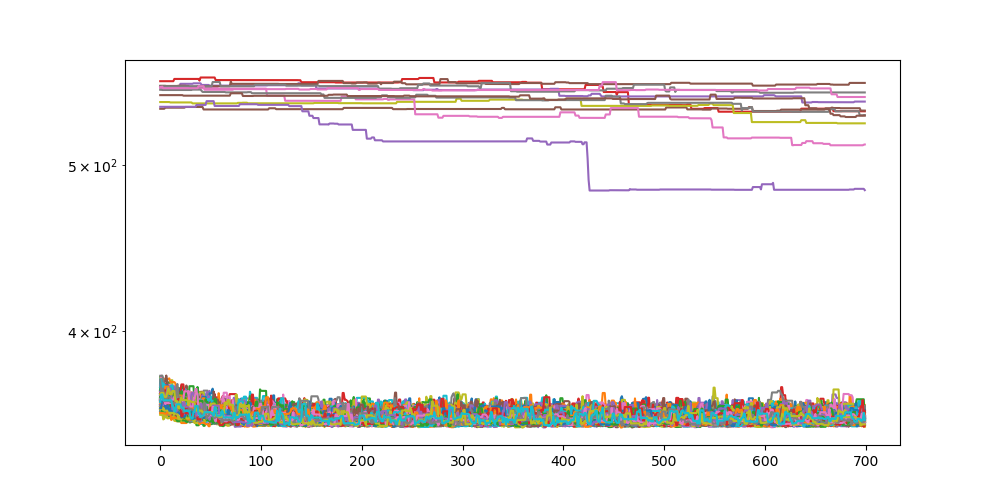

In [97]:
f, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(np.arange(sampler.lnprobability.shape[-1]), -sampler.lnprobability.T);

<IPython.core.display.Javascript object>


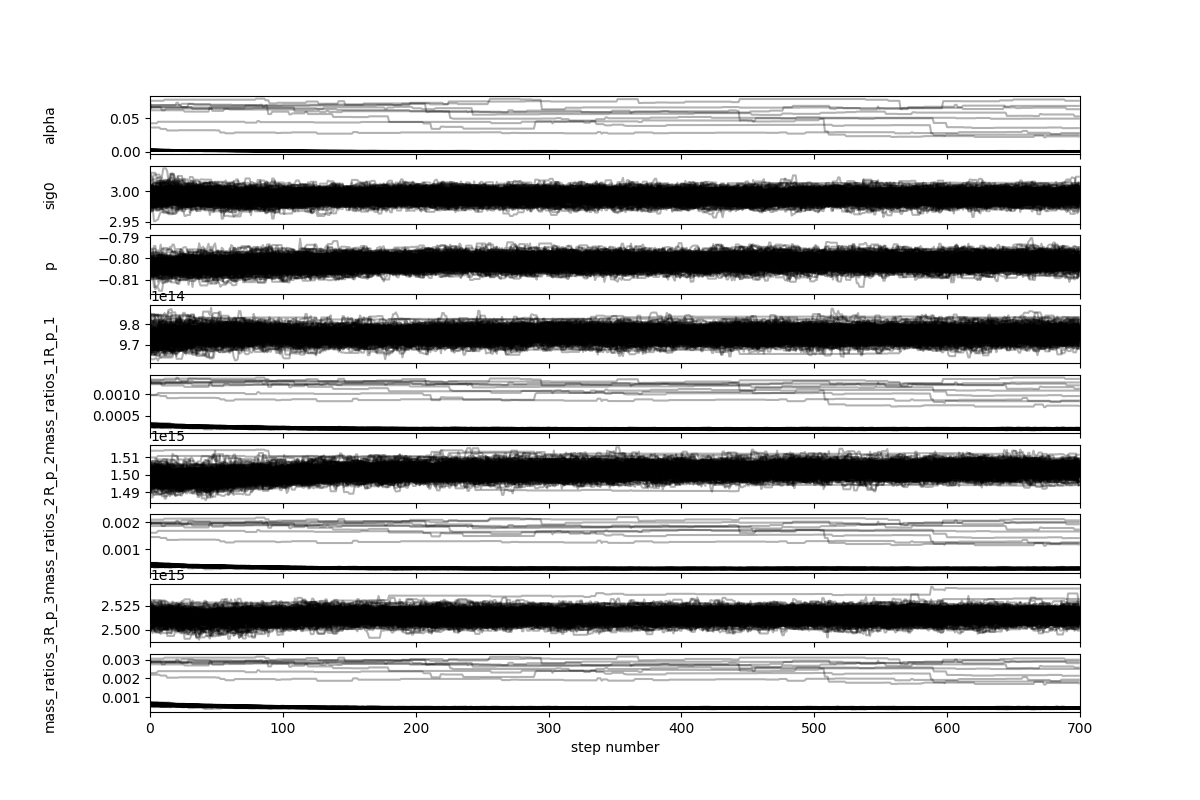

In [85]:
fig, axes = plt.subplots(ndim, figsize=(12, 8), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "sig0", "p"]
if set_alpha == 1:
    labels = labels[1:]
for i in range(gl_n_planets):
    labels.append("R_p"+"_"+str(i+1))
    labels.append("mass_ratios"+"_"+str(i+1))
    
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [91]:
flat_samples = sampler.get_chain(discard=200, flat=True)
means = []
mcmc = []
print("50th percentiles:")
for i in range(ndim):
    means += [np.mean(flat_samples[:,i])]
    mcmc += [np.percentile(flat_samples[:, i], 50)]
    print(labels[i], ":", mcmc[i])
    
print("mean values: ", means)
#print("50th percentiles: ", mcmc)

50th percentiles:
alpha : 0.0010892596765866226
sig0 : 2.990893311396985
p : -0.8015976704973891
R_p_1 : 974976132915600.4
mass_ratios_1 : 0.00018489227768787452
R_p_2 : 1502557082176168.0
mass_ratios_2 : 0.00028742492470050003
R_p_3 : 2514032334484443.0
mass_ratios_3 : 0.00041221076379107296
mean values:  [0.0026158051548125926, 2.9909224497579574, -0.8015875114465818, 974976293136578.1, 0.0002128195545134339, 1502520310956476.0, 0.00032996555392098464, 2514134376826497.5, 0.00047568530275725633]


(150000, 9)


<IPython.core.display.Javascript object>


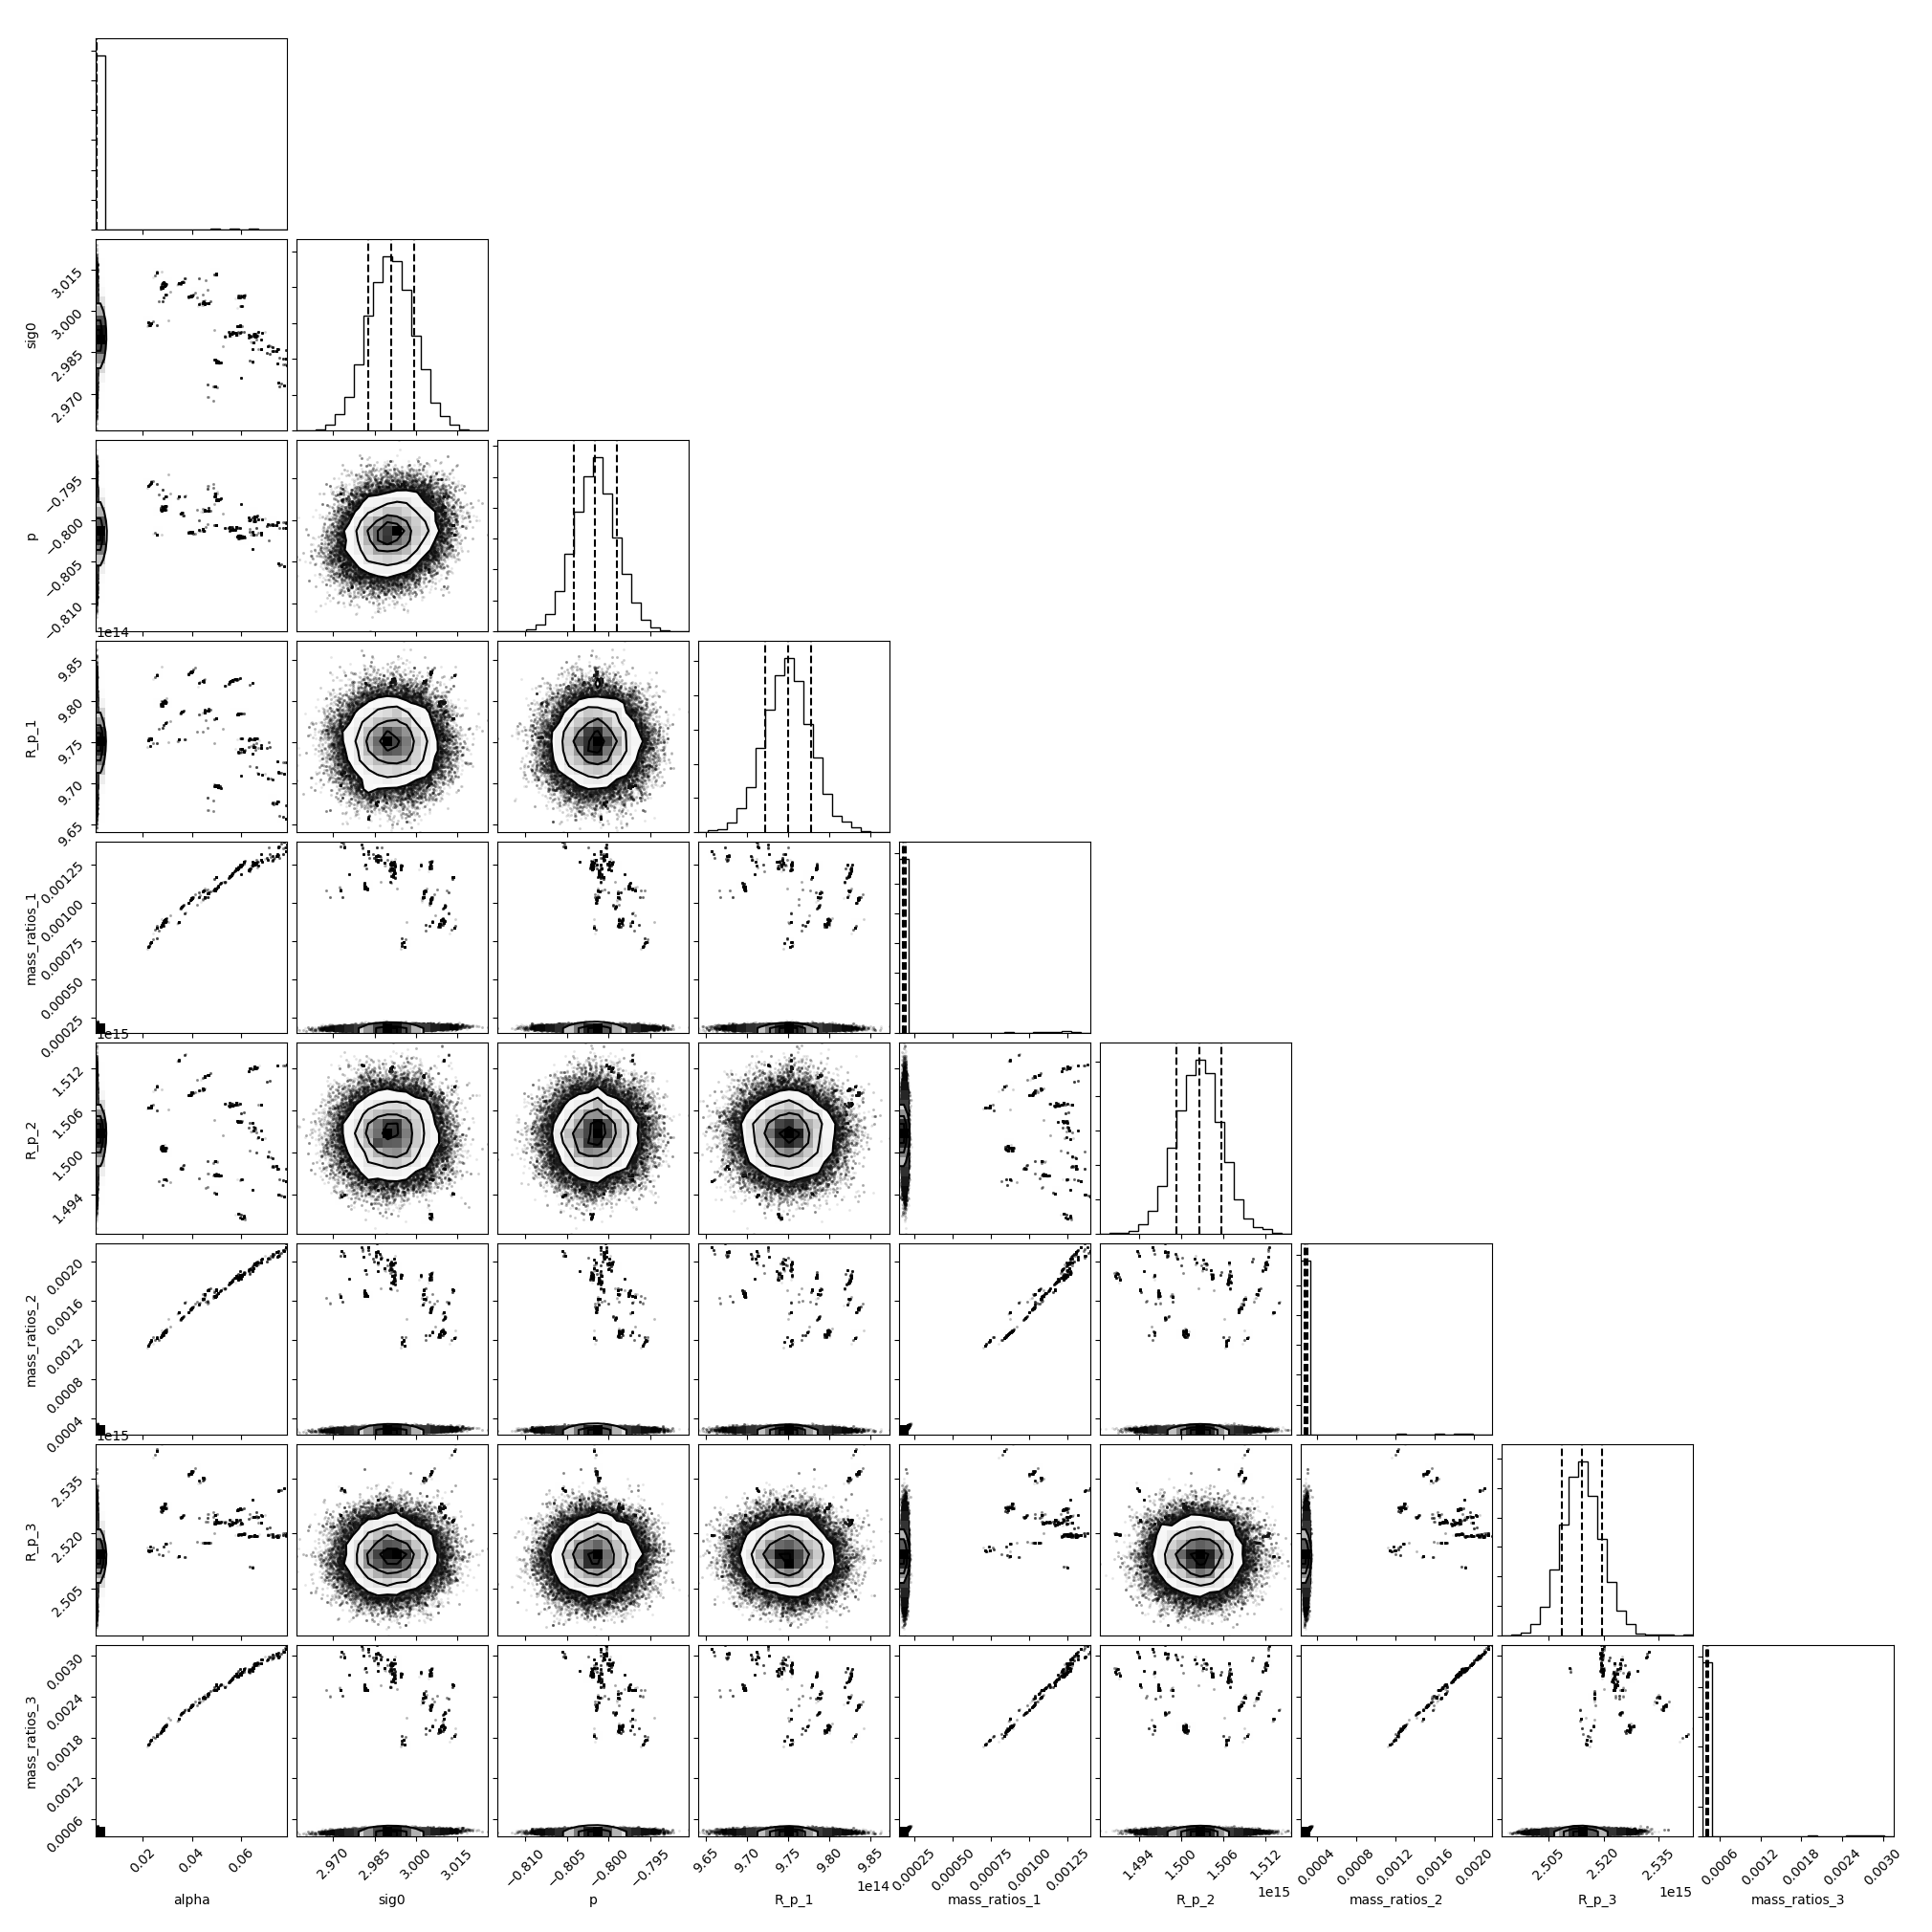

In [92]:
print(flat_samples.shape)
import corner
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

In [93]:
if set_alpha == 1:
    def params_format(params, x_data, y_data, n_planets):
        params = np.insert(params,0,gl_alpha)
        alpha = params[0]
        sig0  = params[1]
        p     = params[2]
        R_p   = []
        mass_ratios = []
        h_p = []
        for n in range(n_planets):
            R_p         += [params[3 + 2 * n]]
            mass_ratios += [params[4 + 2 * n]]
            h_p += [np.interp(R_p, x_data, get_disk_height(x_data))[n]]

        return x_data, alpha, sig0, p, R_p, h_p, mass_ratios

<IPython.core.display.Javascript object>


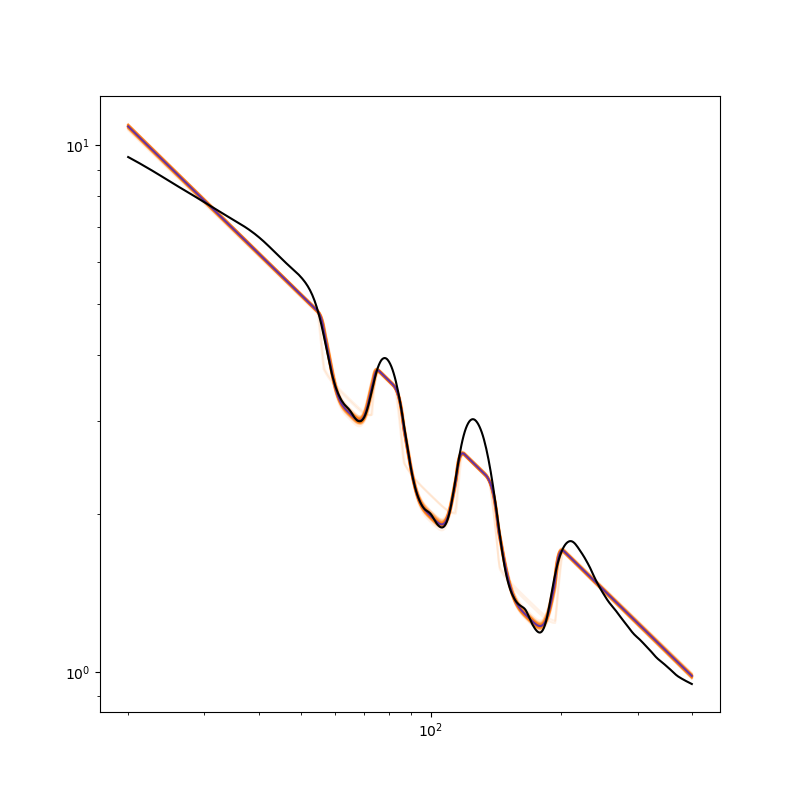

In [94]:
inds = np.random.randint(len(flat_samples), size=100)
f, ax2 = plt.subplots(figsize=(8, 8))
for ind in inds:
    sample = flat_samples[ind]
    x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(sample, r_log, sig, gl_n_planets)
    ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios), "C1", alpha=0.1)
    
x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(mcmc, r_log, sig, gl_n_planets)
ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios), "b", alpha=0.6)
ax2.loglog(r_log[0:] / au, sig[0:], "k-");

#print("50th percentiles: alpha: {:.3f}, Sigma: {:.2f}, p: {:.2f}, R_p: {:.3e}, h_p: {:.3e}, mass ratio: {:.2e}".format(a, s, p, rp, hp, m))
print("50th percentile, parameters in cgs units:")
for i in range(ndim):
    print(labels[i], " :", conv_params_model(mcmc, r, 1)[i])
    